# Stroke Prediction using Machine Learning

## Importing libraries

In [1]:
! pip install lightgbm
! pip install xgboost
! pip install imbalanced-learn

import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn import metrics as mt
from lightgbm import LGBMClassifier
from sklearn.linear_model import RidgeClassifierCV
from xgboost import XGBClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as Xgb
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgm
from sklearn.svm import NuSVC
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import RidgeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, classification_report,f1_score,confusion_matrix,precision_score,recall_score
import warnings
warnings.filterwarnings('ignore')

/home/pearlruby/anaconda3/lib/python3.9/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


## Creating data frame 

In [2]:
file_path = '/home/pearlruby/Project/stroke prediction/healthcare-dataset-stroke-data.csv'
df = pd.read_csv(file_path)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


**Elucidate:**

The last column "stroke" is the response column whereas rest of the columns are predictors. They are independent to each other but response column can be dependent on the predictors. 0 and 1 represent whether a patient had stroke or not, specifically 0 represents no stroke and represents yes stroke.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


- The shape of the data set before pre-processing is 5110 rows * 12 columns.
- Column index represents the response and the rest represent predictors
- There are 5 categorical features and the rest are numerical ones
- All the columns have either values (numerical/categorical) or null replacers such as 'NaN', '', etc.. We are unable to confirm that the dataset doesn't contain any missing values.
- Visually, we see that predictor "bmi" has 201 not applicable values. Since the number is a way lesser than 30% of the total, we delete the respective rows.

In [4]:
print('Feature column names:', df.loc[:, df.columns != 'stroke'].columns)

print('\nTarget column labels:', df['stroke'].unique())

Feature column names: Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status'],
      dtype='object')

Target column labels: [1 0]


In [5]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [6]:
df = df.dropna()
#df = df.reset_index()
print('New shape:', df.shape)

New shape: (4909, 12)


* The missing values are dropped and then the dataframe is reindex.

## Data pre-processing

### Outlier detection and handling

<AxesSubplot:>

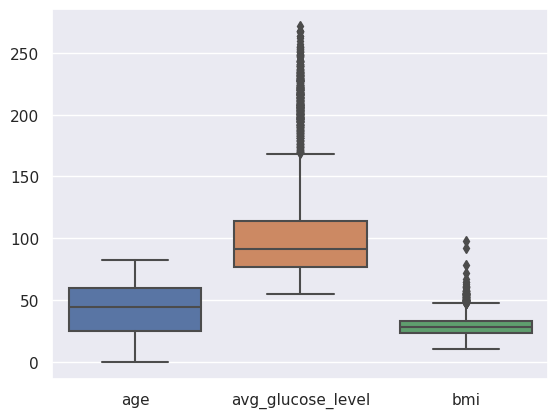

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

sns.boxplot(data = df[['age', 'avg_glucose_level', 'bmi']], orient = 'v')

* With a simple box plot, one can detect outliers.
* An outlier really affects a model performance, so most common method of handing it is to remove it.
* We are doing box plots for there columns such as "age", "avg_glucose_level", and "bmi". Visually we conclude that column age doesn't have an outlier but columns avg_glucose_level and bmi have many outliers which need to handled before fitting the data with a model 

In [8]:
# define the lower and upper bounds for outliers
q1 = df['avg_glucose_level'].quantile(0.25)
q3 = df['avg_glucose_level'].quantile(0.75)

iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

df = df[(df['avg_glucose_level'] >= lower_bound) & (df['avg_glucose_level'] <= upper_bound)]
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1
10,12109,Female,81.0,1,0,Yes,Private,Rural,80.43,29.7,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5104,14180,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


568 rows are filter based on the outlier detection criteria as these data points are placed not within the lower bound and upper bound.

In [9]:
# define the lower and upper bounds for outliers
q1 = df['bmi'].quantile(0.25)
q3 = df['bmi'].quantile(0.75)

iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

df = df[(df['bmi'] >= lower_bound) & (df['bmi'] <= upper_bound)]
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1
10,12109,Female,81.0,1,0,Yes,Private,Rural,80.43,29.7,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5104,14180,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


90 rows were removed as soon as we knew that they were outliers. The number is approximately 6.3 times smaller tha the rows of average level of gluscose column.

In [10]:
df = df.dropna()
df = df.reset_index()
print('New shape:', df.shape)

New shape: (4252, 13)


In [11]:
df = df.drop(['index'], axis = 1)

In [12]:
duplicate_rows = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows.shape)

number of duplicate rows:  (0, 12)


In [13]:
df['work_type'].unique()

array(['Private', 'Govt_job', 'Self-employed', 'children', 'Never_worked'],
      dtype=object)

* Knowing about unique values of a feature is very important in the data visualisation part.

In [14]:
df['smoking_status'].unique()

array(['never smoked', 'Unknown', 'smokes', 'formerly smoked'],
      dtype=object)

In [15]:
df = df.drop('id', axis = 1)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
1,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
2,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
3,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1
4,Female,81.0,1,0,Yes,Private,Rural,80.43,29.7,never smoked,1


* Column id is dropped since it has no use to prediction.

<AxesSubplot:xlabel='work_type', ylabel='Count'>

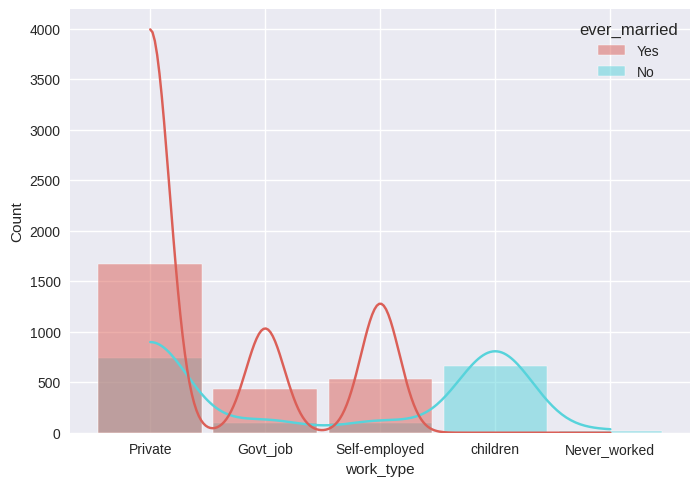

In [16]:
plt.style.use("seaborn")
plt.subplots_adjust(hspace=0.2)
color = 'winter'

sns.histplot(data = df, kde=True, palette = 'hls',  x = 'work_type', hue = 'ever_married', shrink = .9)

* More than 1600 people who were not bachelor and employed privately had stroke. Around 750 bachelor people who worksed private had stroke.
* Greater than 450 people who were not bachelor and have Government jobs has stroke. More than 100 people who were bachelors had stroke.
* More than 500 people who were self employeed and married had stroke. Greater than 100 people who were never married had stroke. 
* From all the above observations, we can clearly note that married people with atleast 1 stroke in their medical history is twice as the bachelor people.  
* There was 0 case under married childern catergory. It is now evident that child marriage is not happening in the population. 
* People who never worked didn't have stroke attack. We see that people never worked will not have stroke. 
* People in private job type has a huge number of stroke cases when campared to Government job and self-employed people. 

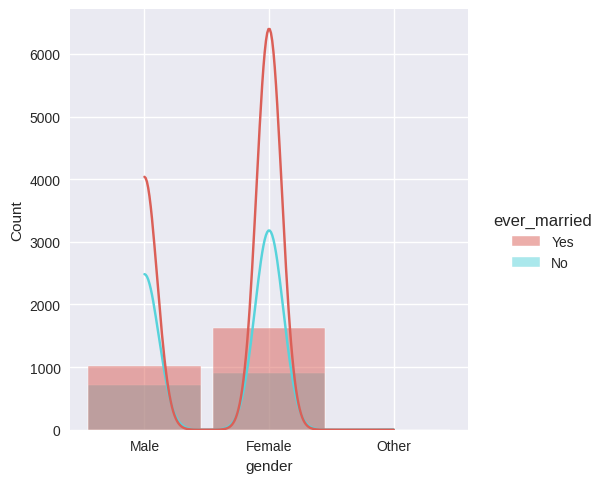

In [17]:
sns.displot(df, x = 'gender', kde=True, palette = 'hls', hue = 'ever_married', shrink = .9)

* The density of females who are married have high chances of getting a stroke because in this sample married females had stroke with significantly larger value than married male. 

* The density of female bachelors has 600 to 700 strokes more than male bachelors.

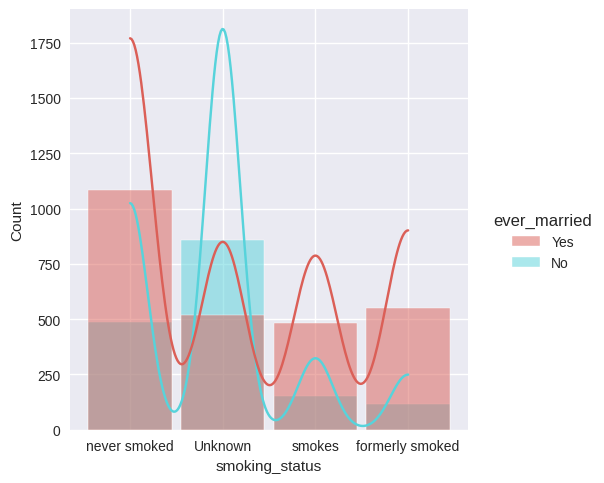

In [18]:
sns.displot(df, x = 'smoking_status', kde=True, palette = 'hls', hue = 'ever_married', shrink = .9)
plt.show()

* Surprisingly, the group of people who regularly smoked had less number of stroke. Among them, bachelors were less than 40% of the total people.
* Contradictoryly, married people who never smoked had srokes higher in number than all of smoking status. Among them, again bachelors were less than 45% of the total people.
* We easily conclude based on the sample that person who doesn't smoke may have stroke with high chances than who smokes.

In [19]:
le = preprocessing.LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])
df['ever_married'] = le.fit_transform(df['ever_married'])
df['Residence_type'] = le.fit_transform(df['Residence_type'])
df['work_type'] = le.fit_transform(df['work_type'])
df['smoking_status'] = le.fit_transform(df['smoking_status'])

##### Label encoding: 
Columns such as gender, ever_married, residence_type, work_type, and smoking status are categorical by default. In order to put use them in prediction, they have to undergo label encoding transformation.

## Feature selection

In [20]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(df).shape

(4252, 8)

Features that have high variance values are considered to be least contributing to predicting model. Using VarianceThreshold from sklearn, we can find and filter columns with high variance. In our sample dataset, there is no significant column with high variance. So all the columns are taken as features to be put into model.

In [21]:
sel.fit_transform(df)

array([[  1.  ,  80.  ,   1.  , ..., 105.92,  32.5 ,   2.  ],
       [  1.  ,  74.  ,   1.  , ...,  70.09,  27.4 ,   2.  ],
       [  0.  ,  69.  ,   0.  , ...,  94.39,  22.8 ,   2.  ],
       ...,
       [  0.  ,  35.  ,   1.  , ...,  82.99,  30.6 ,   2.  ],
       [  1.  ,  51.  ,   1.  , ..., 166.29,  25.6 ,   1.  ],
       [  0.  ,  44.  ,   1.  , ...,  85.28,  26.2 ,   0.  ]])

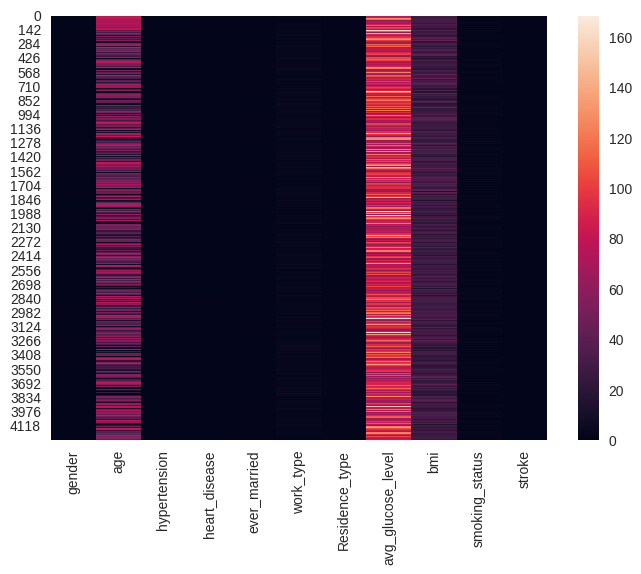

In [22]:
sns.heatmap(df)
plt.show()

The above heatmap plot shows columns that have high variances. Columns age, average_glucose_level, and bmi have high variances. Hence they are visually appearable.

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
gender,1.000000,-0.049177,0.017520,0.086704,-0.051940,0.066232,-0.002015,0.032890,-0.003419,-0.055259,-0.003539
age,-0.049177,1.000000,0.249416,0.236374,0.688758,-0.396312,0.009422,-0.025759,0.382835,0.296266,0.210005
hypertension,0.017520,0.249416,1.000000,0.105966,0.149164,-0.059817,-0.003960,-0.000662,0.154148,0.115662,0.119761
heart_disease,0.086704,0.236374,0.105966,1.000000,0.105596,-0.033394,-0.014132,0.005137,0.056063,0.063443,0.093013
ever_married,-0.051940,0.688758,0.149164,0.105596,1.000000,-0.377834,0.000744,-0.007641,0.375854,0.278207,0.089853
work_type,0.066232,-0.396312,-0.059817,-0.033394,-0.377834,1.000000,-0.003096,0.017231,-0.358736,-0.335554,-0.027304
Residence_type,-0.002015,0.009422,-0.003960,-0.014132,0.000744,-0.003096,1.000000,-0.015736,0.012797,0.019050,0.000023
avg_glucose_level,0.032890,-0.025759,-0.000662,0.005137,-0.007641,0.017231,-0.015736,1.000000,0.002005,-0.003273,0.005831
bmi,-0.003419,0.382835,0.154148,0.056063,0.375854,-0.358736,0.012797,0.002005,1.000000,0.265864,0.032117
smoking_status,-0.055259,0.296266,0.115662,0.063443,0.278207,-0.335554,0.019050,-0.003273,0.265864,1.000000,0.041069


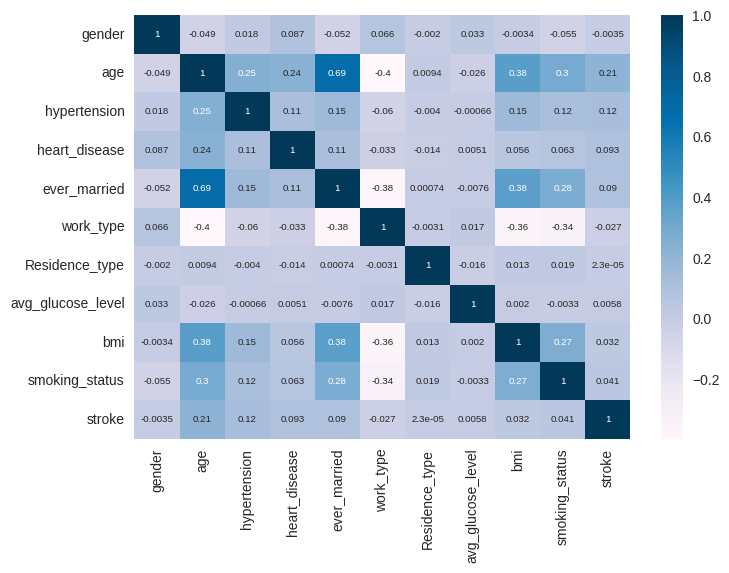

In [23]:
corr = df.corr()
sns.heatmap(corr, cmap= "PuBu", annot = True, annot_kws={'size': 7})
corr

This correlation map shows degree of similarity and relationship between all the features. Variables ever_married and age have the highest correlation cofficient as 0.69. Variables stroke and residence_type have the least correlation coefficient value as 0.000023.

## Basic summary statistics

In [24]:
df.mean()

gender                0.406632
age                  40.598655
hypertension          0.068674
heart_disease         0.036453
ever_married          0.620414
work_type             2.203669
Residence_type        0.507291
avg_glucose_level    91.513173
bmi                  27.777046
smoking_status        1.343603
stroke                0.031985
dtype: float64

In [25]:
df.median()

gender                0.000
age                  41.000
hypertension          0.000
heart_disease         0.000
ever_married          1.000
work_type             2.000
Residence_type        1.000
avg_glucose_level    88.055
bmi                  27.400
smoking_status        2.000
stroke                0.000
dtype: float64

In [26]:
df.mode()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,45.0,0,0,1,2,1,93.88,28.7,2,0


In [27]:
df.std()

gender                0.491741
age                  22.460205
hypertension          0.252928
heart_disease         0.187438
ever_married          0.485341
work_type             1.111267
Residence_type        0.500006
avg_glucose_level    22.713855
bmi                   6.676779
smoking_status        1.082896
stroke                0.175981
dtype: float64

In [28]:
df.var()

gender                 0.241810
age                  504.460817
hypertension           0.063973
heart_disease          0.035133
ever_married           0.235556
work_type              1.234915
Residence_type         0.250006
avg_glucose_level    515.919197
bmi                   44.579374
smoking_status         1.172664
stroke                 0.030969
dtype: float64

In [29]:
scale = StandardScaler()

variables = df[['age', 'avg_glucose_level', 'bmi']]
scaled_variables = scale.fit_transform(variables)

df['age'] = scaled_variables[:, 0]
df['avg_glucose_level'] = scaled_variables[:, 1]
df['bmi'] = scaled_variables[:, 2]

In [30]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,1.754480,0,1,1,2,0,0.634349,0.707453,2,1
1,1,1.487309,1,1,1,2,0,-0.943287,-0.056478,2,1
2,0,1.264667,0,0,0,2,1,0.126670,-0.745514,2,1
3,0,1.665423,0,0,1,2,1,-1.450526,-0.535807,0,1
4,0,1.799008,1,0,1,2,0,-0.488005,0.288040,2,1
...,...,...,...,...,...,...,...,...,...,...,...
4247,0,-1.228925,0,0,0,4,0,0.509301,-1.374634,0,0
4248,0,1.799008,0,0,1,3,1,1.483270,1.830882,2,0
4249,0,-0.249299,0,0,1,3,0,-0.375285,0.422852,2,0
4250,1,0.463156,0,0,1,2,0,3.292511,-0.326101,1,0


## Prediction with classifiers

In [31]:
y, X = df['stroke'], df.drop('stroke', axis = 1)
X_train, x_test, Y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

* We split the preprocessed dataset into training and testing sets with sizes 0.7 and 0.3 of total size. Random state parameter is set to 42.

In [32]:
X_train

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
1091,1,0.774855,0,0,1,0,1,0.419918,0.542684,0
382,0,0.641269,0,0,1,3,0,-0.674257,0.018417,2
1474,1,-1.184396,0,0,0,4,0,2.549705,-1.075053,0
3780,1,-1.050811,0,0,0,2,0,-0.429003,2.534897,2
1653,1,-1.273453,0,0,0,4,0,0.204165,-1.359655,0
...,...,...,...,...,...,...,...,...,...,...
3444,0,-1.006283,0,0,0,1,1,-0.430765,-0.925262,2
466,0,1.709952,0,0,1,2,1,-0.931839,-0.715556,1
3092,1,-1.451567,0,0,0,4,0,-0.635509,-1.629278,0
3772,0,-1.050811,0,0,0,2,0,-0.523670,-0.925262,2


In [33]:
Y_train

1091    0
382     0
1474    0
3780    0
1653    0
       ..
3444    0
466     0
3092    0
3772    0
860     0
Name: stroke, Length: 2976, dtype: int64

In [34]:
x_test

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
184,0,-0.471941,0,0,1,2,1,-1.323717,1.336573,3
2576,0,-0.516470,0,0,1,3,0,-0.985998,-0.146352,2
2542,2,-0.650055,0,0,0,2,0,2.281556,-0.805430,1
3873,0,-0.739112,0,0,1,2,0,2.858364,-0.116394,1
958,1,1.220139,0,0,1,3,1,-1.327679,-0.191289,1
...,...,...,...,...,...,...,...,...,...,...
2510,0,1.398253,0,0,1,3,0,0.551571,1.036992,1
4207,0,-0.694584,0,0,0,2,1,0.024077,-0.371038,3
2640,0,0.463156,0,0,1,0,0,0.616737,0.452810,2
2381,1,-0.560998,0,0,1,3,1,2.859245,-0.520828,2


In [35]:
y_test

184     0
2576    0
2542    0
3873    0
958     0
       ..
2510    0
4207    0
2640    0
2381    0
883     0
Name: stroke, Length: 1276, dtype: int64

In [73]:
value = 0.1
n = 1
accuracy = []

while n < 10:
    X_train, x_test, Y_train, y_test = train_test_split(X, y, test_size = value)
    
    DTclassifier = DecisionTreeClassifier(max_depth = 1)
    DTclassifier.fit(X_train, Y_train)
    predict = DTclassifier.predict(x_test)
    accuracy += [accuracy_score(y_test, predict)]
    
    value += .1
    n += 1
    
print(accuracy)
accuracy.index(max(accuracy))

[0.9694835680751174, 0.9647473560517039, 0.9702194357366771, 0.9723691945914168, 0.9694261523988711, 0.9698275862068966, 0.9674168626133691, 0.9673721340388007, 0.9683825450744709]


3

* We find that optimal split ratio for the test set size is 0.4 since it yields the highest prediction accuracy.

In [75]:
value = 1
n = 1
accuracy0 = []

while n < 100:
    X_train, x_test, Y_train, y_test = train_test_split(X, y, test_size = 0.6, random_state = value)
    
    DTclassifier = DecisionTreeClassifier(max_depth = 1)
    DTclassifier.fit(X_train, Y_train)

    predict = DTclassifier.predict(x_test)
    accuracy0 += [accuracy_score(y_test, predict)]
    
    value += 1
    n += 1
    
print(accuracy0)
accuracy0.index(max(accuracy0))

[0.9690438871473355, 0.9678683385579937, 0.969435736677116, 0.9678683385579937, 0.9682601880877743, 0.969435736677116, 0.9670846394984326, 0.9690438871473355, 0.9698275862068966, 0.9663009404388715, 0.9690438871473355, 0.9686520376175548, 0.9670846394984326, 0.9659090909090909, 0.9702194357366771, 0.9670846394984326, 0.9706112852664577, 0.9655172413793104, 0.9674764890282131, 0.9674764890282131, 0.9690438871473355, 0.9651253918495298, 0.9678683385579937, 0.9674764890282131, 0.9663009404388715, 0.9674764890282131, 0.9655172413793104, 0.9643416927899686, 0.966692789968652, 0.9682601880877743, 0.9659090909090909, 0.9702194357366771, 0.9702194357366771, 0.9713949843260188, 0.9682601880877743, 0.969435736677116, 0.9655172413793104, 0.9678683385579937, 0.9670846394984326, 0.9710031347962382, 0.9686520376175548, 0.9706112852664577, 0.9674764890282131, 0.9713949843260188, 0.9651253918495298, 0.9663009404388715, 0.963166144200627, 0.9710031347962382, 0.9647335423197492, 0.9643416927899686, 0.96

33

We also find that random state as 33 performs very good compared to all other values between 0 to 99 with 0.6 as the optimal test split ration.

In [76]:
sm = SMOTE(random_state = 42)
X_train_resampled, Y_train_resampled = sm.fit_resample(X_train, Y_train)

SMOTE is a technique to do over-sampling of the data.

In [77]:
classifiers = [#DecisionTreeClassifier(),
               RandomForestClassifier(),
               SGDClassifier(),
               SVC(),
               XGBClassifier(),
               RidgeClassifier(),
               LinearSVC(),
               AdaBoostClassifier(),
               MLPClassifier(),
               ExtraTreesClassifier(),
               Perceptron(),
               GaussianNB(),
               KNeighborsClassifier(),
               NearestCentroid(),
               LogisticRegression(),
               BaggingClassifier(),
               BernoulliNB(),
               CalibratedClassifierCV(),
               QuadraticDiscriminantAnalysis()]

accuracy = []
accuracyBalanced = []
precisionAvg = []
brier_score_loss = []
f1 = []
precision_score = []
recall_score = []
jaccard_score = []
roc_auc_score = []

for classifier in classifiers:
    classifier.fit(X_train_resampled, Y_train_resampled)
    predict = classifier.predict(x_test)

    accuracy += [mt.accuracy_score(y_test, predict)]
    accuracyBalanced += [mt.balanced_accuracy_score(y_test, predict)]
    precisionAvg += [mt.average_precision_score(y_test, predict)]
    brier_score_loss += [mt.brier_score_loss(y_test, predict)]
    f1 += [mt.f1_score(y_test, predict)]
    precision_score += [mt.precision_score(y_test, predict)]
    recall_score += [mt.recall_score(y_test, predict)]
    jaccard_score += [mt.jaccard_score(y_test, predict)]
    roc_auc_score += [mt.roc_auc_score(y_test, predict)]

We compute almost all the model performance metrics for almost all the classifers.

In [42]:
df_metrics = pd.DataFrame({'Classifier': classifiers,
                   'Accuracy': accuracy,
                   'AccuracyBalanced': accuracyBalanced,
                   'PrecisionAvg': precisionAvg,
                   'BrierScoreLoss': brier_score_loss,
                   'F1': f1,
                   'PrecisionScore': precision_score,
                   'RecallScore': recall_score,
                   'JaccardScore': jaccard_score,
                   'RocAucScore': roc_auc_score})
    
df_metrics.head(20)

,Classifier,Accuracy,AccuracyBalanced,PrecisionAvg,BrierScoreLoss,F1,PrecisionScore,RecallScore,JaccardScore,RocAucScore
0,"(DecisionTreeClassifier(max_features='auto', r...",0.917366,0.539381,0.034238,0.082634,0.088889,0.065574,0.137931,0.046512,0.539381
1,SGDClassifier(),0.729594,0.671207,0.050605,0.270406,0.116356,0.064320,0.609195,0.061772,0.671207
2,SVC(),0.817938,0.594078,0.040176,0.182062,0.102649,0.059961,0.356322,0.054101,0.594078
3,"XGBClassifier(base_score=None, booster=None, c...",0.912664,0.564829,0.039561,0.087336,0.115646,0.082126,0.195402,0.061372,0.564829
4,RidgeClassifier(),0.750420,0.676359,0.052652,0.249580,0.122786,0.068421,0.597701,0.065409,0.676359
5,LinearSVC(),0.762177,0.682415,0.054626,0.237823,0.128079,0.071724,0.597701,0.068421,0.682415
6,"(DecisionTreeClassifier(max_depth=1, random_st...",0.795096,0.610184,0.042168,0.204904,0.105572,0.060504,0.413793,0.055728,0.610184
7,MLPClassifier(),0.870675,0.587796,0.041470,0.129325,0.114943,0.071839,0.287356,0.060976,0.587796
8,"(ExtraTreeClassifier(random_state=1427349299),...",0.920054,0.551913,0.037107,0.079946,0.105263,0.078212,0.160920,0.055556,0.551913
9,Perceptron(),0.932818,0.586358,0.050321,0.067182,0.159664,0.125828,0.218391,0.086758,0.586358


A generated dataframe that consists of classifiers and their performance metric scores.

### Deployement will be done in future version of this notebook. Happy learning :)